In [45]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from mdgp.bo_experiment.experiment import ExperimentConfig
import warnings 

In [46]:
def flatten_dict(d, parent_key=''):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}.{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key).items())
        else:
            items.append((new_key, v))
    return dict(items)


def read_config(path) -> pd.DataFrame:
    return pd.DataFrame([flatten_dict(ExperimentConfig.from_json(path).to_dict())])


def collect_and_combine_dataframes(dir_path, config_file_name='config.json', metrics_file_name='bo/metrics.csv'):
    # List to hold dataframes
    dfs = []
    
    # Walking through the directory tree
    for root, dirs, files in os.walk(dir_path):
        # print(files)
        if config_file_name in files:
            # Constructing the file paths
            config_file_path = os.path.join(root, config_file_name)
            metrics_file_path = os.path.join(root, metrics_file_name)
            
            if os.path.exists(metrics_file_path) is False: 
                continue

            # Reading the files into dataframes
            config_df = read_config(config_file_path)
            metrics_df = pd.read_csv(metrics_file_path)
            config_df = pd.concat([config_df] * len(metrics_df), ignore_index=True)
            
            # Joining the dataframes
            joined_df = config_df.join(metrics_df)
            
            # Appending the joined dataframe to the list
            dfs.append(joined_df)
    
    # Combining all the joined dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

# Example usage:
# combined_df = collect_and_combine_dataframes('/path/to/directory', 'config_file.csv', 'metrics_file.csv')


In [47]:
df = collect_and_combine_dataframes('../../experiments/bo/')
df = df[[
    'best_y', 
    'run', 
    'step', 
    'model_arguments.model_name', 
    'bo_arguments.switch_to_deep_iter', 
    'data_arguments.target_function_name', 
    'model_arguments.acqf_name',
]].astype({'best_y': 'float64', 'run': int, 'step': int})

In [48]:
def log10_simple_regret(x, minimum=0):
    return np.log10(x - minimum)

df['simple_regret'] = log10_simple_regret(df['best_y'])

/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
ackley = df['data_arguments.target_function_name'] == 'ackley'
perm_sph_harm = df['data_arguments.target_function_name'] == 'perm_sph_harm'
exact = df['model_arguments.model_name'] == 'exact'
ei = df['model_arguments.acqf_name'] == 'expected_improvement'
dgp_sample = df['data_arguments.target_function_name'] == 'dgp_sample'
deep = df['model_arguments.model_name'] == 'deep'

In [6]:
df[ei & exact & perm_sph_harm]['run'].value_counts()

run
0     200
6     200
18    200
9     200
1     200
19    200
12    200
13    200
3     200
11    200
14    200
5     200
15    200
2     200
16    200
17    200
4     200
7     200
8     200
10    200
Name: count, dtype: int64

## Reproducing results from MaternGaBO

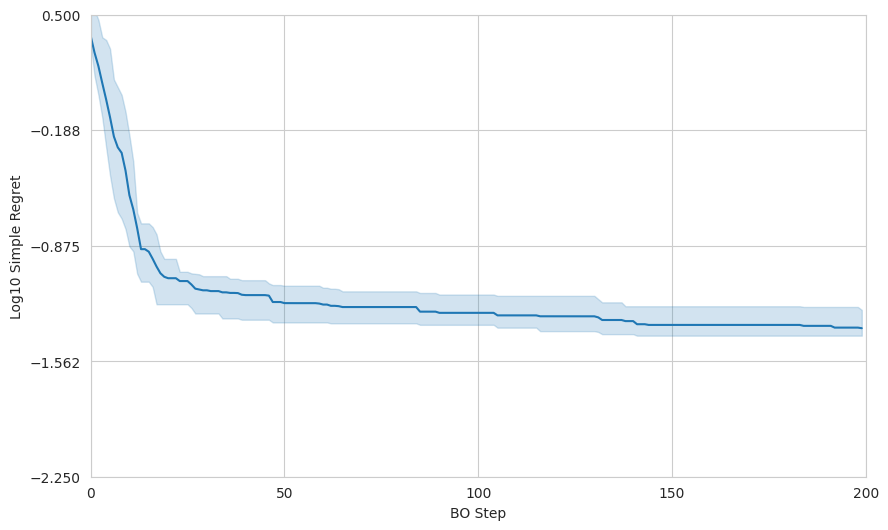

In [25]:
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

data = df[ackley & exact & ei].drop(columns=['data_arguments.target_function_name', 'model_arguments.model_name', 'bo_arguments.switch_to_deep_iter', 'model_arguments.acqf_name'])



# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='step', y='simple_regret', estimator='mean', errorbar=('pi', 50))

# Setting the y-axis range and ticks
plt.ylim(-2.25, 0.5)
plt.yticks(np.linspace(-2.25, 0.5, 5))
plt.xlim(0, 200)
plt.xticks(np.linspace(0, 200, 5))

# Renaming the axes
plt.xlabel("BO Step")
plt.ylabel("Log10 Simple Regret")

# Showing the plot
plt.show()

## Exact GP results on sample from DGP

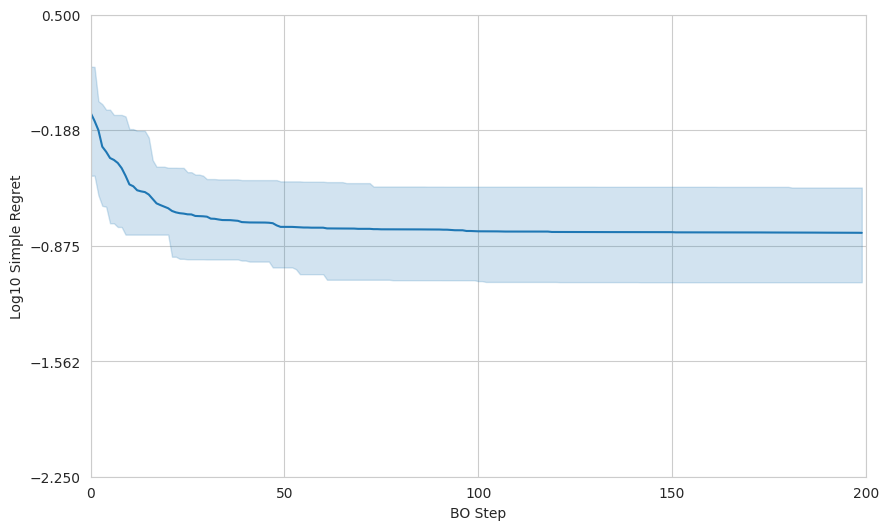

In [27]:
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

data = df[dgp_sample & exact & ei].drop(columns=['data_arguments.target_function_name', 'model_arguments.model_name', 'bo_arguments.switch_to_deep_iter', 'model_arguments.acqf_name'])



# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='step', y='best_y', estimator='mean', errorbar=('pi', 50))

# Setting the y-axis range and ticks
plt.ylim(-2.25, 0.5)
plt.yticks(np.linspace(-2.25, 0.5, 5))
plt.xlim(0, 200)
plt.xticks(np.linspace(0, 200, 5))

# Renaming the axes
plt.xlabel("BO Step")
plt.ylabel("Log10 Simple Regret")

# Showing the plot
plt.show()

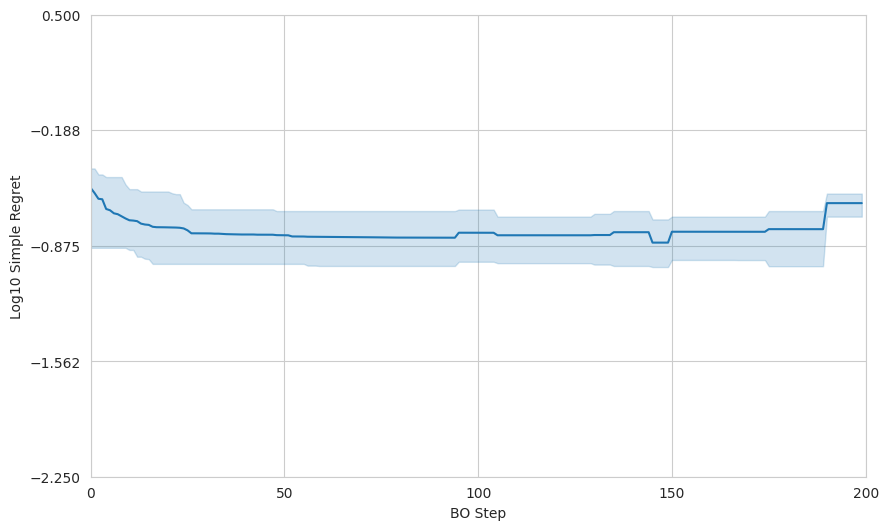

In [28]:
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

data = df[dgp_sample & deep & ei].drop(columns=['data_arguments.target_function_name', 'model_arguments.model_name', 'bo_arguments.switch_to_deep_iter', 'model_arguments.acqf_name'])



# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='step', y='best_y', estimator='mean', errorbar=('pi', 50))

# Setting the y-axis range and ticks
plt.ylim(-2.25, 0.5)
plt.yticks(np.linspace(-2.25, 0.5, 5))
plt.xlim(0, 200)
plt.xticks(np.linspace(0, 200, 5))

# Renaming the axes
plt.xlabel("BO Step")
plt.ylabel("Log10 Simple Regret")

# Showing the plot
plt.show()

### Deep GP

In [50]:
switch_to_dgp = df['bo_arguments.switch_to_deep_iter'] == 100
# data = df[switch_to_dgp]

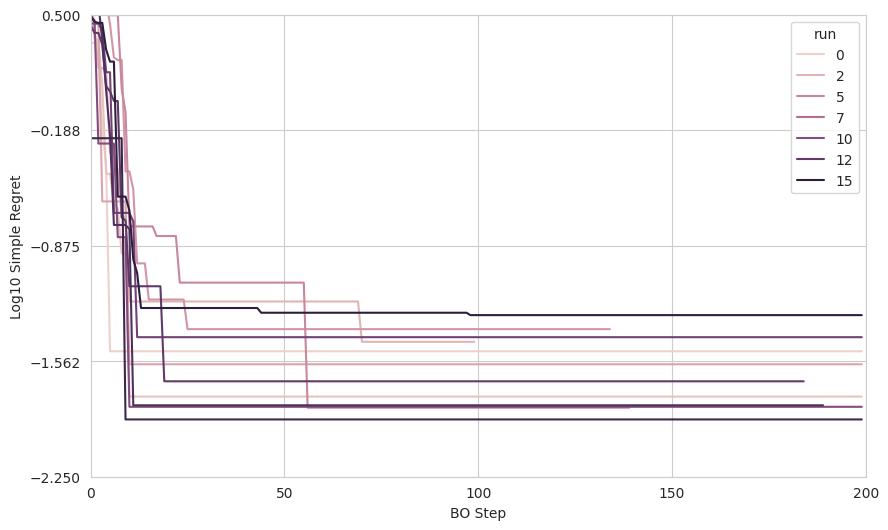

In [30]:
sns.set_style('whitegrid')


# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='step', y='simple_regret', hue='run')#estimator='mean', errorbar=('pi', 50))

# Setting the y-axis range and ticks
plt.ylim(-2.25, 0.5)
plt.yticks(np.linspace(-2.25, 0.5, 5))
plt.xlim(0, 200)
plt.xticks(np.linspace(0, 200, 5))

# Renaming the axes
plt.xlabel("BO Step")
plt.ylabel("Log10 Simple Regret")

# Showing the plot
plt.show()

In [20]:
def plot_mean(data, x='step', y='best_y'): 
    # Creating the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, estimator='mean', errorbar=('pi', 50))

    # Setting the y-axis range and ticks
    plt.ylim(-2.25, 0.5)
    plt.yticks(np.linspace(-2.25, 0.5, 5))
    plt.xlim(0, 200)
    plt.xticks(np.linspace(0, 200, 5))

    plt.axhline(y=-0.7, color='grey', linestyle='--')

    # Renaming the axes
    plt.xlabel(x)
    plt.ylabel(y)

    # Showing the plot
    plt.show()


def plot_runs(data, x='step', y='best_y'): 
    # Creating the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, hue='run')

    # Setting the y-axis range and ticks
    plt.ylim(-2.25, 0.5)
    plt.yticks(np.linspace(-2.25, 0.5, 5))
    plt.xlim(0, 200)
    plt.xticks(np.linspace(0, 200, 5))

    plt.axhline(y=-0.7, color='grey', linestyle='--')

    # Renaming the axes
    plt.xlabel(x)
    plt.ylabel(y)

    # Showing the plot
    plt.show()

In [44]:
print(data[data['run'] == 9]['best_y'].iloc[50:80])

19690   -0.232787
19691   -0.232787
19692   -0.232787
19693   -0.232787
19694   -0.232787
19695   -0.232787
19696   -0.232787
19697   -0.232795
19698   -0.232795
19699   -0.232795
19700   -0.232795
19701   -0.232795
19702   -0.232795
19703   -0.232795
19704   -0.232795
19705   -0.320306
19706   -0.424277
19707   -0.555804
19708   -0.555804
19709   -0.555804
19710   -0.555804
19711   -0.555804
19712   -0.555804
19713   -0.555804
19714   -0.555804
19715   -0.555804
19716   -0.584290
19717   -0.584290
19718   -0.584290
19719   -0.584290
Name: best_y, dtype: float64


/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages

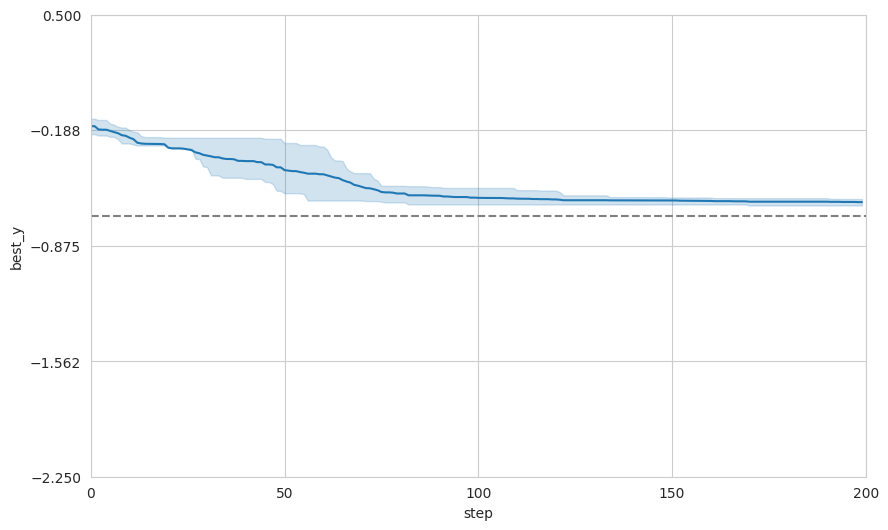

/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_

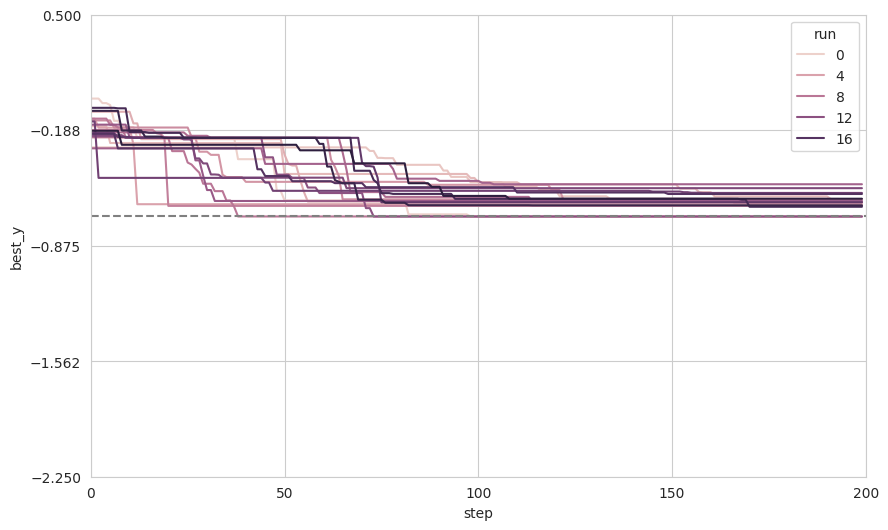

/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_

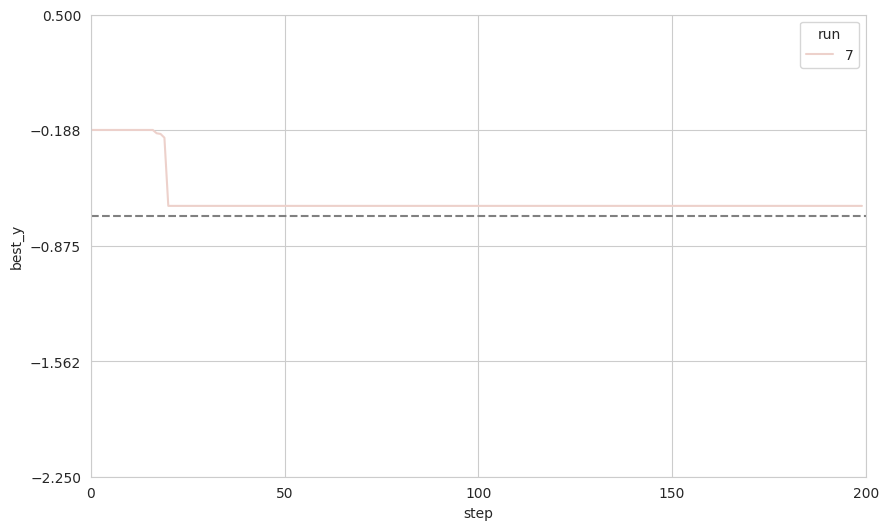

In [51]:
data = df[exact & ei & perm_sph_harm]
plot_mean(data)
plot_runs(data)
plot_runs(data[data['run'] == 7])

/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages

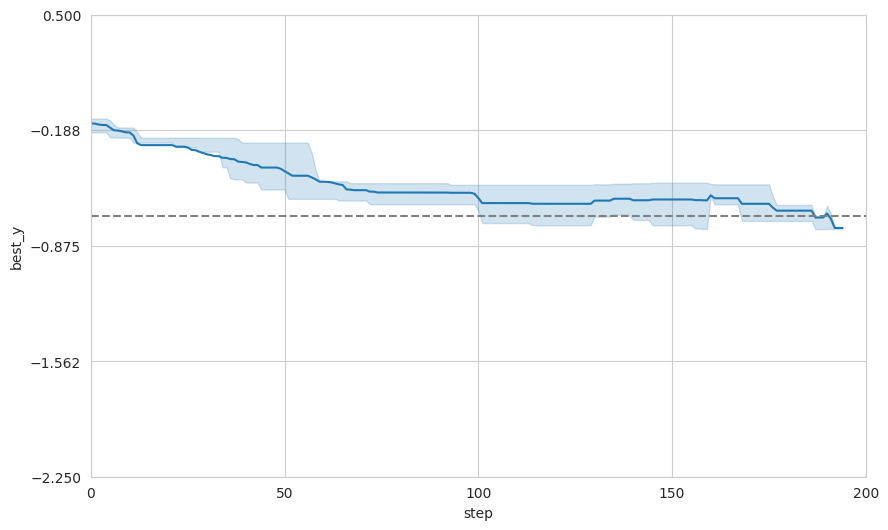

/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/seaborn/_

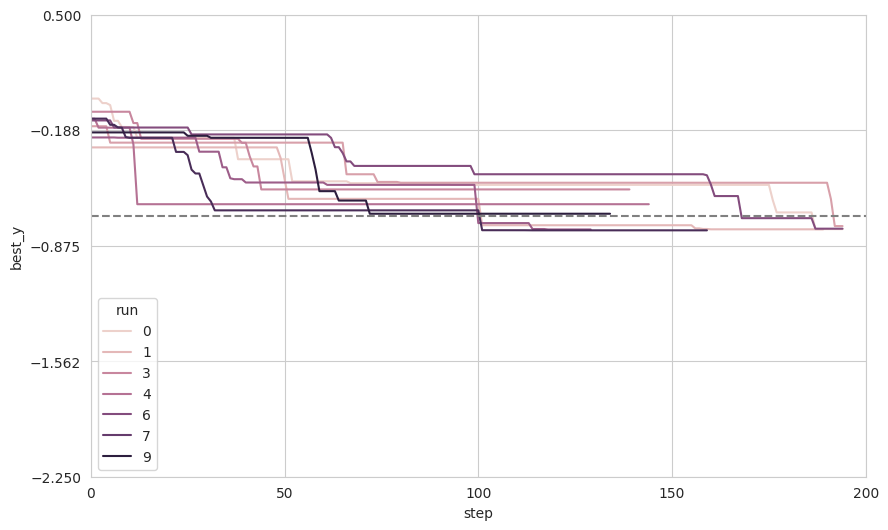

In [54]:
data = df[deep & ei & perm_sph_harm & switch_to_dgp]
data = data[data['run'] != 7]
plot_mean(data)
plot_runs(data)